# Importações

In [29]:
import pandas as pd
import numpy as np
import os
from google.colab import drive
import joblib

# Importações de ML
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report

# Importações de Reamostragem
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#Montar o Google Drive


In [ ]:
drive.mount('/content/drive')
output_path = '/content/drive/MyDrive/Ps_Ligia_Time_16/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

Mounted at /content/drive


#Carregar Datasets


In [42]:
datasets = {
    "Base": pd.read_csv(os.path.join(output_path, 'risco_cardiovascular_base.csv')),
    "Features": pd.read_csv(os.path.join(output_path, 'risco_cardiovascular_features.csv'))
}

#Definição de Modelos e Hiperparâmetros para GridSearch

In [22]:
'''
Aqui criamos o grid de todos modelos com seus respectivos hiperparametros que
vão ser combinados no gridsearch para acharmos a melhor configuração.

Com a pipeline do imblearn tambem é possivel adicionar resampler ou qualquer
pré-processamento pro grid

'''
resampler = [
    SMOTE(random_state=42),
    RandomOverSampler(random_state=42),
    RandomUnderSampler(random_state=42),
    'passthrough'
]

models_config = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'resampler': resampler,
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [None, 5, 10],
            'classifier__min_samples_split': [2, 5]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'resampler': resampler,
            'classifier__max_depth': [None, 3, 5, 10],
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    }
}

#Loop de Treinamento


In [43]:
model_save_path = os.path.join(output_path, 'models')
os.makedirs(model_save_path, exist_ok=True)

results_list = []

for ds_name, df in datasets.items():
    print(f"\n>>> Processando Dataset: {ds_name}")

    # Separar X e y
    X = df.drop('BP_Category', axis=1)
    y = df['BP_Category']

    # Identificar colunas
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()
    num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

    # Preprocessor
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

    # Split Treino/Teste (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


    for model_name, config in models_config.items():
        print(f"\n--- Iniciando GridSearch para {model_name} ---")

        # Pipeline base com placeholder para o resampler
        pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', SMOTE()), # Placeholder que será substituído pelo Grid
            ('classifier', config['model'])
        ])

        # Cross-Validation (10 Folds para dataset pequeno)
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

        # Grid Search
        grid = GridSearchCV(
            pipeline,
            config['params'],
            cv=cv,
            scoring=['f1_macro', 'accuracy'],
            refit='f1_macro',
            n_jobs=-1,
            verbose=1
        )

        grid.fit(X_train, y_train)

        cv_res = pd.DataFrame(grid.cv_results_)

        # Métricas de Validação (do melhor modelo)
        best_idx = grid.best_index_
        val_f1 = grid.best_score_
        val_acc = cv_res.loc[best_idx, 'mean_test_accuracy']

        # Métricas de Teste
        y_pred = grid.predict(X_test)
        test_f1 = f1_score(y_test, y_pred, average='macro')
        test_acc = accuracy_score(y_test, y_pred)

        # Salvar Modelo no Drive
        model_filename = f"{model_name}_{ds_name}.pkl"
        joblib.dump(grid.best_estimator_, os.path.join(model_save_path, model_filename))

        # Armazenar resultados
        results_list.append({
            'Model': model_name,
            'Dataset': ds_name,
            'Best_Params': str(grid.best_params_),
            'Val_F1_Macro': val_f1,
            'Val_Accuracy': val_acc,
            'Test_F1_Macro': test_f1,
            'Test_Accuracy': test_acc,
        })


>>> Processando Dataset: Base

--- Iniciando GridSearch para RandomForest ---
Fitting 10 folds for each of 72 candidates, totalling 720 fits

--- Iniciando GridSearch para DecisionTree ---
Fitting 10 folds for each of 96 candidates, totalling 960 fits

>>> Processando Dataset: Features

--- Iniciando GridSearch para RandomForest ---
Fitting 10 folds for each of 72 candidates, totalling 720 fits

--- Iniciando GridSearch para DecisionTree ---
Fitting 10 folds for each of 96 candidates, totalling 960 fits


# Resultados

In [45]:
df_results = pd.DataFrame(results_list)

# Criar tabelas separadas por modelo
for model_name in models_config.keys():
    df_model = df_results[df_results['Model'] == model_name].copy()

    # Salvar no Drive
    filename = f"resultado_final_{model_name}.csv"
    df_model.to_csv(os.path.join(output_path, filename), index=False)

    print(f"\n--- Tabela Final: {model_name} ---")
    display(df_model[['Dataset', 'Val_F1_Macro', 'Val_Accuracy', 'Test_F1_Macro', 'Test_Accuracy', 'Best_Params']])

print(f"\nProcesso concluído! Os arquivos foram salvos em: {output_path}")


--- Tabela Final: RandomForest ---


,Dataset,Val_F1_Macro,Val_Accuracy,Test_F1_Macro,Test_Accuracy,Best_Params
0,Base,0.983358,0.983218,0.987464,0.986667,"{'classifier__max_depth': None, 'classifier__m..."
2,Features,0.980131,0.980000,1.000000,1.000000,"{'classifier__max_depth': None, 'classifier__m..."



--- Tabela Final: DecisionTree ---


,Dataset,Val_F1_Macro,Val_Accuracy,Test_F1_Macro,Test_Accuracy,Best_Params
1,Base,0.970136,0.969655,0.929989,0.933333,"{'classifier__criterion': 'entropy', 'classifi..."
3,Features,0.979350,0.980000,0.974017,0.973333,"{'classifier__criterion': 'gini', 'classifier_..."



Processo concluído! Os arquivos foram salvos em: /content/drive/MyDrive/Ps_Ligia_Time_16/


# Feature Importance (Exclusivo do RandomForest e DecisionTree)

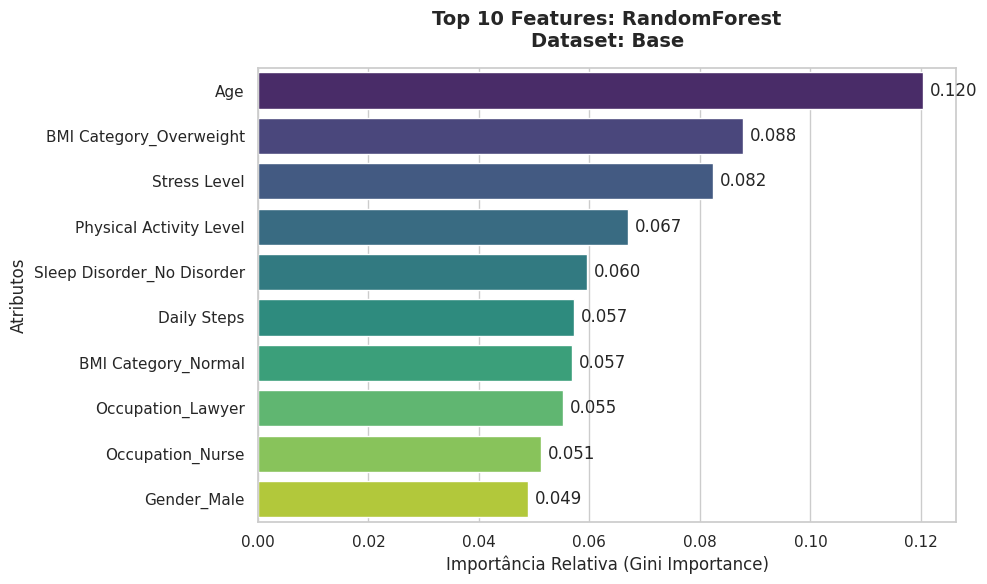

✅ Gráfico de importância para RandomForest (Base) salvo com sucesso.


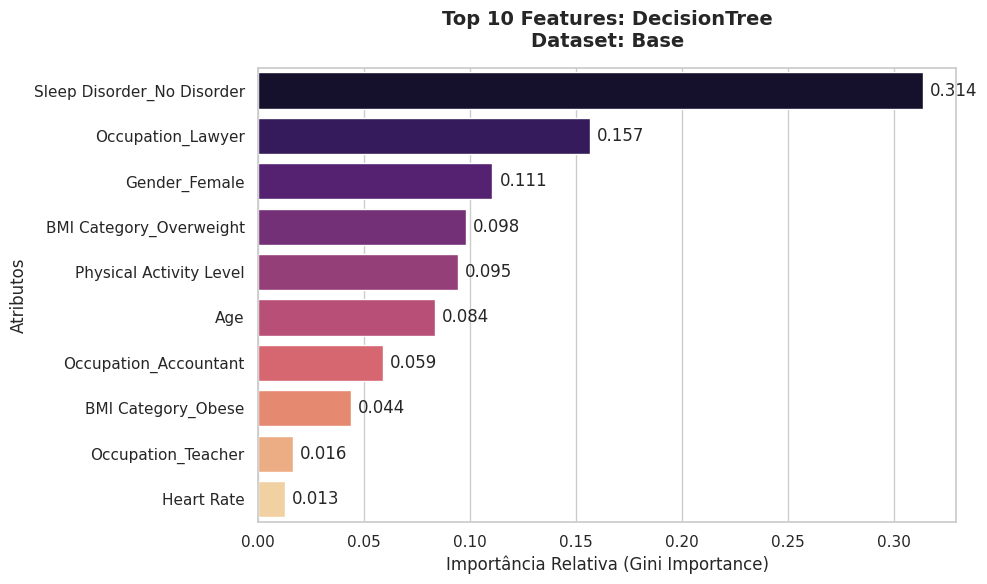

✅ Gráfico de importância para DecisionTree (Base) salvo com sucesso.


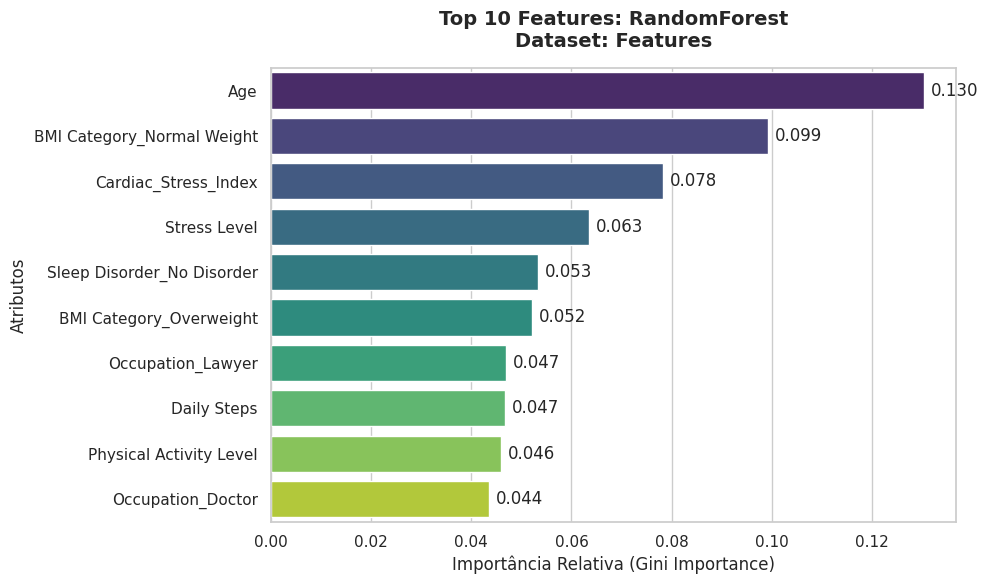

✅ Gráfico de importância para RandomForest (Features) salvo com sucesso.


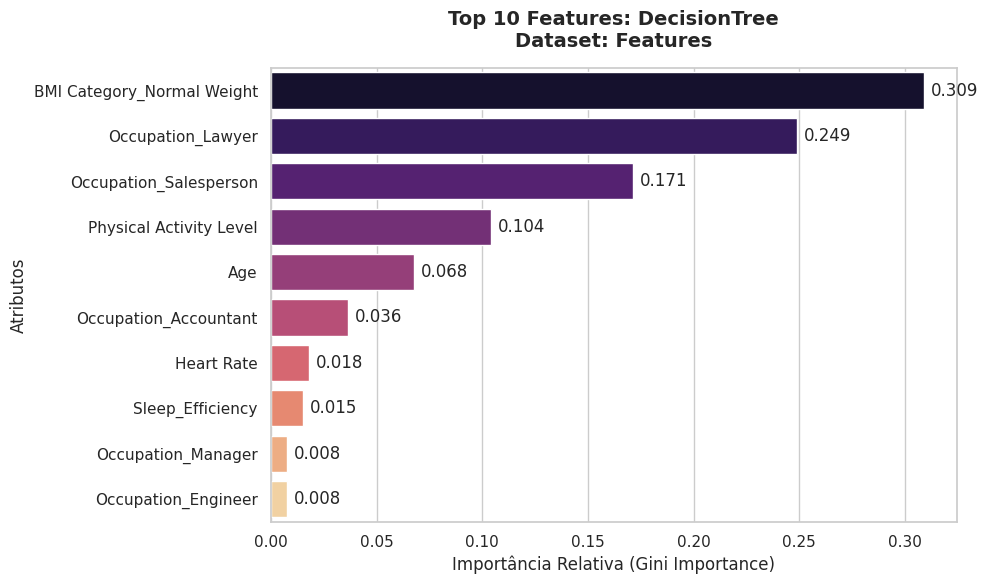

✅ Gráfico de importância para DecisionTree (Features) salvo com sucesso.


In [37]:
# --- Célula: Visualização da Importância das Features ---
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

def gerar_graficos_importancia(results_list, model_save_path, output_path):
    """
    Carrega os modelos salvos e gera gráficos de importância das features
    para cada combinação de Modelo e Dataset.
    """
    # Configuração visual
    sns.set_theme(style="whitegrid")

    for res in results_list:
        model_name = res['Model']
        ds_name = res['Dataset']

        # Caminho do modelo salvo no Drive
        path_modelo = os.path.join(model_save_path, f"{model_name}_{ds_name}.pkl")

        if os.path.exists(path_modelo):
            # Carregar o pipeline completo (inclui preprocessor e classifier)
            pipeline = joblib.load(path_modelo)

            # 1. Recuperar nomes das colunas (considerando o One-Hot Encoding)
            # O get_feature_names_out() extrai os nomes gerados pelo ColumnTransformer
            preprocessor = pipeline.named_steps['preprocessor']
            feature_names = preprocessor.get_feature_names_out()

            # Limpar nomes (remover prefixos técnicos 'num__' e 'cat__')
            feature_names = [name.split('__')[-1] for name in feature_names]

            # 2. Extrair importâncias do classificador (RF ou DT)
            classifier = pipeline.named_steps['classifier']
            importances = classifier.feature_importances_

            # 3. Criar DataFrame para organizar o Top 10
            df_imp = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values(by='Importance', ascending=False).head(10)

            # 4. Criação do Gráfico
            plt.figure(figsize=(10, 6))
            cores = 'viridis' if model_name == 'RandomForest' else 'magma'

            ax = sns.barplot(
                data=df_imp,
                x='Importance',
                y='Feature',
                palette=cores,
                hue='Feature',
                legend=False
            )

            # Estilização
            plt.title(f"Top 10 Features: {model_name}\nDataset: {ds_name}", fontsize=14, fontweight='bold', pad=15)
            plt.xlabel("Importância Relativa (Gini Importance)", fontsize=12)
            plt.ylabel("Atributos", fontsize=12)

            # Adicionar os valores numéricos nas pontas das barras para precisão
            for i in ax.containers:
                ax.bar_label(i, fmt='%.3f', padding=5)

            plt.tight_layout()

            # Salvar o gráfico no Drive
            nome_arquivo = f"feat_imp_{model_name}_{ds_name}.png"
            plt.savefig(os.path.join(output_path, nome_arquivo), dpi=300)
            plt.show()
            print(f"✅ Gráfico de importância para {model_name} ({ds_name}) salvo com sucesso.")
        else:
            print(f"⚠️ Modelo {model_name}_{ds_name}.pkl não encontrado no caminho especificado.")

# Execução automática
gerar_graficos_importancia(results_list, model_save_path, output_path)